# Flood Mapping_Sentinel-4-Africa-DRR
<img src="https://uni-bonn.sciebo.de/s/XjjZLJ9uB4aaPJs/download" width="1000"/>


# Optical-based Flood Mapping

***

The objective of this notebook  is to determine the extent of flooded areas using Sentinel-2 optical satellite imagery. The use of Sentinel imagery provides a quick assessment of the flood extent. The processing of Sentinel-2 satellite imagery is simple to process to delienate water surfaces from other land covers. In this notebook, the most common approach; tresholding, is applied to map flooded land surfaces from non flooded. A major limitation to the use of Sentinel 2 optical data remains to be cloud cover especially during adverse weather conditions which is when flood events are common.

***

***Work Flow***  
The Jupyter Notebook begins first by importing the required libraries. The next step will involve generation of an Area of Interest*'(AOI)'* with the current version, the user is required to defined the upper left and lower right coordinates of the bounding box which is then used to create a geojson file of the boundary. Sentinel 2 image scenes covering the AOI are then queried from <a href="https://scihub.copernicus.eu/">Copernicus Open Access Hub</a> with the help of *'SentinelSat API'*. The resulting scenes from the query are then stored in an iterable list. The user can then visualize the scenes in a map using *'Folium'* library. 

The identified scene is then downloaded into the working directory and unzipped. The unzipped image with *'.SAFE'* is read using the *Eoreader* library which also computes the Normalized Difference Water Index(NDWI).
A global treshold is applied on the computed NDWI and the image is binarized to separate water and non-water pixels. The binarized image is then written to a folder.

<img src="https://uni-bonn.sciebo.de/s/MhwRRkpp1lyfjME/download" width="1000"/>



***Limitations***  
1.The notebook takes all the scenes that intersect the AOI, but for the processing it can inly process one scene at a time, the user has to choose the scene of interest using an index.

2.The user has to enter an AOI using absolute coordinates

3.The treshold used for separating water and non-water surfaces is a global treshold, a local treshold can be used for better performance


***


In [1]:
import os                                     # data access
import google.colab                           # Google Colab
import time                                   # time assessment
import sys
!pip install geopandas
!pip install pandas
!pip install folium
!pip install numpy
!pip install rasterio
!pip install zipfile
!pip install eoreader
!pip install shapely
!pip install sentinelsat
!pip install leafmap

# status update
with google.colab.output.use_tags('initialization'):
    sys.stdout.write('\nInitialization successful!')
    sys.stdout.flush()
time.sleep(1)
google.colab.output.clear(output_tags='initialization')


ModuleNotFoundError: No module named 'google.colab'

In [2]:
#Loading required libraries 
import pandas as pd
import folium
import geopandas as gpd
import numpy as np
import rasterio as rio
import ipywidgets
import zipfile
import xarray as xr
import leafmap
from shapely import geometry
from shapely.geometry import Polygon
from eoreader.bands import NDWI
from datetime import date
#Sentinelsat
from sentinelsat.sentinel import SentinelAPI, read_geojson,geojson_to_wkt
# EOReader
from eoreader.reader import Reader
from eoreader.bands import RED, GREEN, NDVI,NDWI, YELLOW, CLOUDS, to_str

In [3]:
#Specify coordinates of the bounding box of the AOI(In geographic coordinates). This is the upper left and lower right corners of the bounding box.
lat1=8.342279
lat2=7.411822
lon1=6.411985
lon2=7.491392

In [4]:
# This function creates a geopandas dataframe of the AOi using the upper left and lower right coordinates of the study area
def define_AOI(lon1, lon2, lat1, lat2):
    """
    location is a function to return a geodataframe with rectangular polygon
    geometry from 2 sets of lat/lon points.
    """ 
    p1 = geometry.Point(lon1,lat1)
    p2 = geometry.Point(lon2,lat1)
    p3 = geometry.Point(lon2,lat2)
    p4 = geometry.Point(lon1,lat2)


    pointList = [p1, p2, p3, p4, p1]

    poly = geometry.Polygon([[p.x, p.y] for p in pointList])
    boundary = pd.DataFrame()
    boundary['geometry'] = [poly]
    boundary = gpd.GeoDataFrame(boundary, geometry='geometry', crs={'init': 'epsg:4326'})
    return boundary

In [5]:
# # Visualizing the bounds of the study area in Folium
m = folium.Map([(lat1+lat2)/2, (lon1+lon2)/2], zoom_start=10)
boundary=define_AOI(lon1,lon2,lat1,lat2)

bound = folium.GeoJson(boundary, name='Boundary')
bound.add_to(m)
folium.LayerControl().add_to(m)

In [6]:
#In this cell the Sentinelsat API is used to access the Sentinel 2 images from the Copernicus Access hub.
# The username and password have to be specified
# The date range, the processing level and the cloud coverage have to be specified



geom = boundary['geometry'].iloc[0]

#@title <font color=#1B7192> Click to run </font>  { display-mode: "form" }

####################################################
#################### USER INPUT ####################
####################################################

Username      = ''              #@param {type:"string"}
Password      = ''              #@param {type:"string"}
SensingPeriod_Start  = '2022-09-11'     #@param {type:"date"}
SensingPeriod_Stop   = '2022-11-08'     #@param {type:"date"}

api = SentinelAPI(Username, Password, 'https://scihub.copernicus.eu/dhus')
period = (date(int(SensingPeriod_Start.split('-')[0]), int(SensingPeriod_Start.split('-')[1]), int(SensingPeriod_Start.split('-')[2])),
              date(int(SensingPeriod_Stop.split('-')[0]), int(SensingPeriod_Stop.split('-')[1]), int(SensingPeriod_Stop.split('-')[2])))
products = api.query(geom,
                     date = period,
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0, 10))

gdf = api.to_geodataframe(products)
gdf_sorted = gdf.sort_values(by='ingestiondate')

In [7]:
# The results of the search from the previous cell are visualized in an interactive map, here you can choose which image you would like to process
# Note that the image scenes are ordered according to their date of acquisition
m = folium.Map([(lat1+lat2)/2, (lon1+lon2)/2], zoom_start=8)

bound = folium.GeoJson(boundary, name='Boundary')
folium.Popup("Area of Interest").add_to(bound)
bound.add_to(m)

for j,i in enumerate(gdf_sorted['geometry']):
    bound = folium.GeoJson(i, name='Sentinel_{}'.format(gdf_sorted['ingestiondate'].iloc[j]))
    bound.add_to(m)
    
folium.LayerControl().add_to(m)
m


In [8]:
#Download the scenes of covering the intended study area. The desired scene is specified using their respective index
api.download(gdf_sorted.index[2])
meta = api.download(gdf_sorted.index[2])
folder = meta['title']
# unzip downloaded imagery
with zipfile.ZipFile('{}.zip'.format(folder), 'r') as zip_ref:
    zip_ref.extractall('')

In [9]:
#Opening folder containing the downloaded, unzipped imagery
#Eoreader library required here
folder=folder+".SAFE"
prod = Reader().open(folder)
# Required bands are loaded as a dict of xarray.DataArray.
# Eoreader has an inbuilt library that computes NDWI as one band
band_dict = prod.load([GREEN,NDWI, CLOUDS])
green = band_dict[GREEN]
NDWI = band_dict[NDWI]
clouds = band_dict[CLOUDS]

In [10]:
#Writing the computed DNWI to a file
# Sepcify the name of the NDWI layer file
NDWI.isel(band=0).rio.to_raster("NDWI.tif")

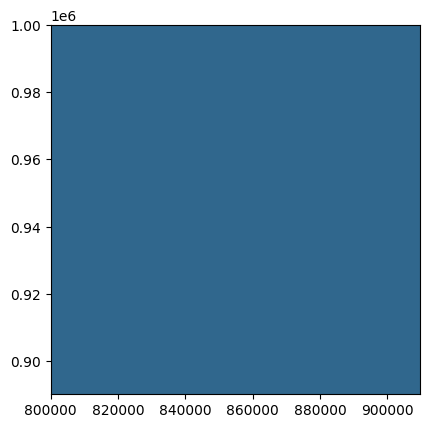

<AxesSubplot: >

In [11]:
# Visualize the NDWI layer
from rasterio.plot import show
ras= rio.open(r"NDWI.tif")
rio.plot.show(ras)

In [12]:
#Function to distinguish between water and non-water surfaces based on a global NDWI water treshold(0.2)
#The result is an xarray.darray binary image
def extract_water(ndwi):
    """
    Extract water from NDWI index (and rename the array)
    """
    # Assert water bodies when NDWI index > 0.2
    water = xr.where(ndwi > 0.2, 1, 0)

    # Set nodata where ndwi is nan.
    # WARNING: the function xr.DataArray.where sets by default np.nan where the condition is false !
    # See here: http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html
    water = water.where(~np.isnan(ndwi))

    # Plot a subsampled version
    water_name = f"{ndwi.attrs['constellation']} WATER"
    water = water.rename(water_name)
    water.attrs["long_name"] = "Water detection"
    return water.rename(water_name)

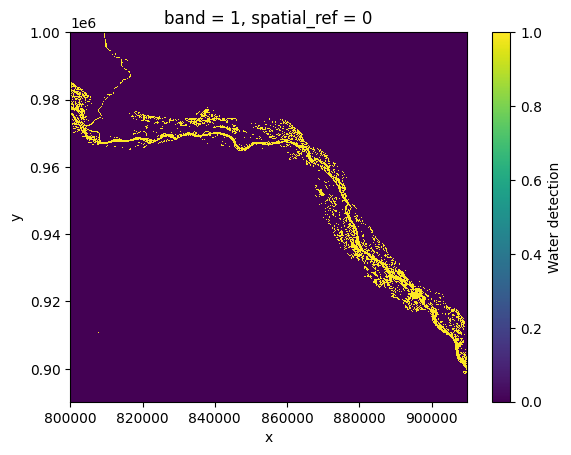

In [13]:
#Applying the function on the NDWI layer and visualizing the result
flood_areas= extract_water(NDWI)
flood_areas.plot()

In [48]:
# Visualizing the flooded areas on top of a leaflet map as an overlay
#The flooded areas will be highlighted in blue

#First we specify a dictionary of the different classes in the raster
raster_to_coloridx={0: (0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 0),
 1: (0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0),
 -128: (1, 1, 1, 0)}

# Create an image overlay layer
overlay = folium.raster_layers.ImageOverlay(
    name='My Image Overlay',
    image=flood_areas[0].values,
    opacity=1,
    bounds=[[(lat1+lat2)/2, (lon1+lon2)/2]],
    colormap=lambda x: raster_to_coloridx[x]).add_to(m)
folium.LayerControl().add_to(m)
m



In [62]:
# Exporting the flood mask in geotiff fromat
#one_pixels.isel(band=0).rio.to_raster("flood_areas.tif")
#Exporting flood mask in SHP format
#Exporting flood mask in Geojson format
# create a new array with values of 1 where the binary raster has a value of 1
#Writing the computed flooded surface to a file
# Sepcify the name of the flood layer file
flood_areas.isel(band=0).rio.to_raster("flood.tif")

/home/victor/python_projects/py_venv/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


ValueError: Source shape (1, 1, 10980, 10980) is inconsistent with given indexes 1

## References and acknowledgement
https://medium.com/analytics-vidhya/unsupervised-flood-detection-with-sentinel-2-satellite-imagery-7a254dc2be2e

https://colab.research.google.com/github/UN-SPIDER/radar-based-flood-mapping/blob/main/resources/notebooks/radar-based-flood-mapping-colab.ipynb#scrollTo=q3yEG-4jW3_V

http://www.acgeospatial.co.uk/sentinelsat_demo/

